In [1]:
# data analysis
import pandas as pd

# visualization
import seaborn as sns
from  matplotlib import pyplot as plt

# sats
from statsmodels.tsa.seasonal import STL

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import r2_score

In [2]:
# Import and clean data

df = pd.read_csv('../../data/processed/qqq_close').drop(columns='Unnamed: 0')
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={"close":"QQQ","US05Y, TVC: Close": "US05Y","US10Y, TVC: Close":"US10Y","US30Y, TVC: Close":"US30Y"}, inplace=True)

In [3]:
df.drop(columns='Volume').corr()

,QQQ,US05Y,US10Y,US30Y
QQQ,1.000000,-0.408306,-0.586338,-0.711703
US05Y,-0.408306,1.000000,0.964207,0.873779
US10Y,-0.586338,0.964207,1.000000,0.968174
US30Y,-0.711703,0.873779,0.968174,1.000000


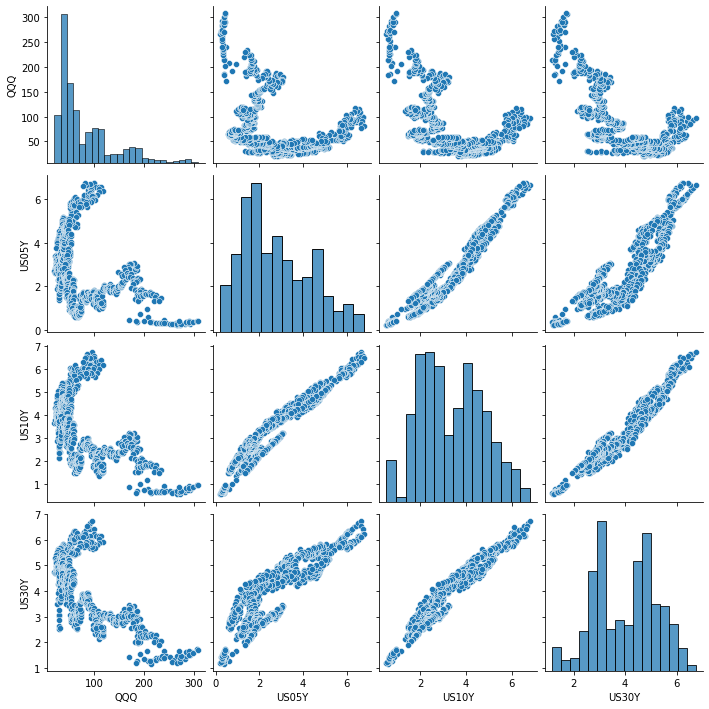

In [4]:
sns.pairplot(df.drop(columns='Volume'))

In [5]:
df.columns

Index(['date', 'QQQ', 'US05Y', 'US10Y', 'US30Y', 'Volume'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    1136 non-null   datetime64[ns, UTC]
 1   QQQ     1136 non-null   float64            
 2   US05Y   1136 non-null   float64            
 3   US10Y   1136 non-null   float64            
 4   US30Y   1136 non-null   float64            
 5   Volume  1136 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 53.4 KB


In [7]:
df.set_index(df['date'],inplace=True)

In [8]:
df['date'].asfreq(freq='w')
df.set_index(df['date'],inplace=True)


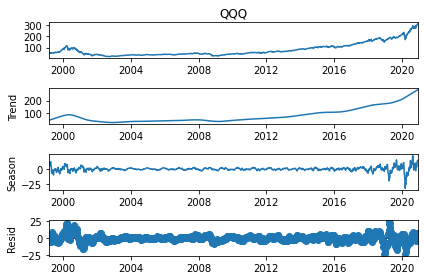

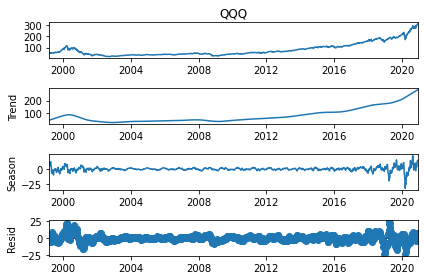

In [9]:
stl = STL(df['QQQ'], period =50)
res = stl.fit()
res.plot()

In [10]:
qqq_trend = res.trend
qqq_seasonal = res.seasonal
qqq_resid = res.resid
qqq_weights = res.weights

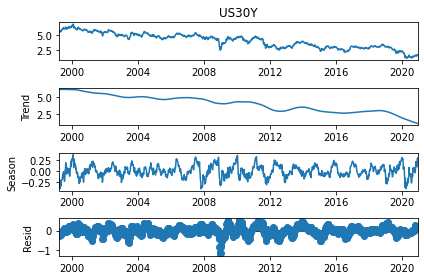

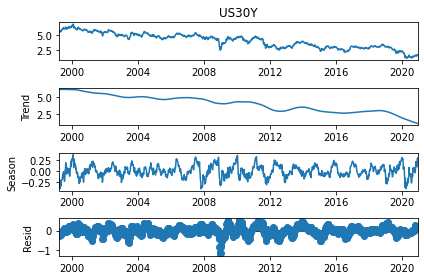

In [11]:
stl = STL(df['US30Y'], period =60)
res2 = stl.fit()
res2.plot()

In [12]:
us30y_trend = res2.trend
us30y_seasonal = res2.seasonal

us30y_resid = res2.resid
us30y_weights = res2.weights

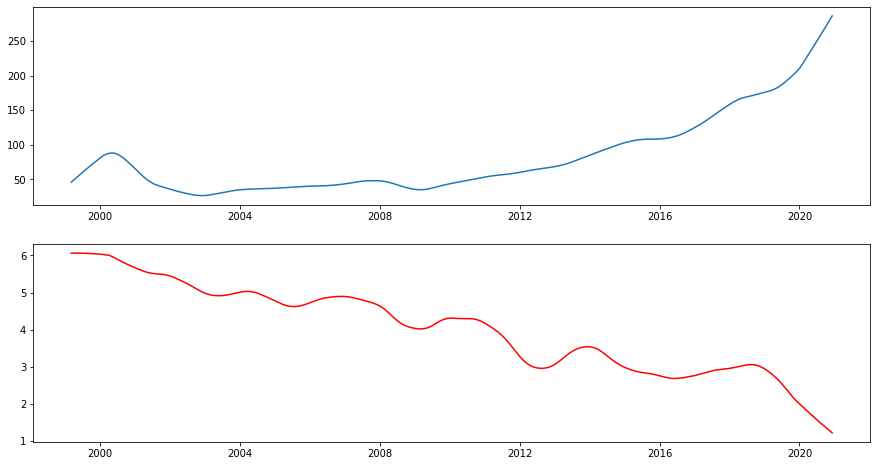

In [13]:
## Trend
fig, ax = plt.subplots(2,figsize=(15,8))
ax[0].plot(qqq_trend)
ax[1].plot(us30y_trend, color = 'r');

- The picture above compares the trend  

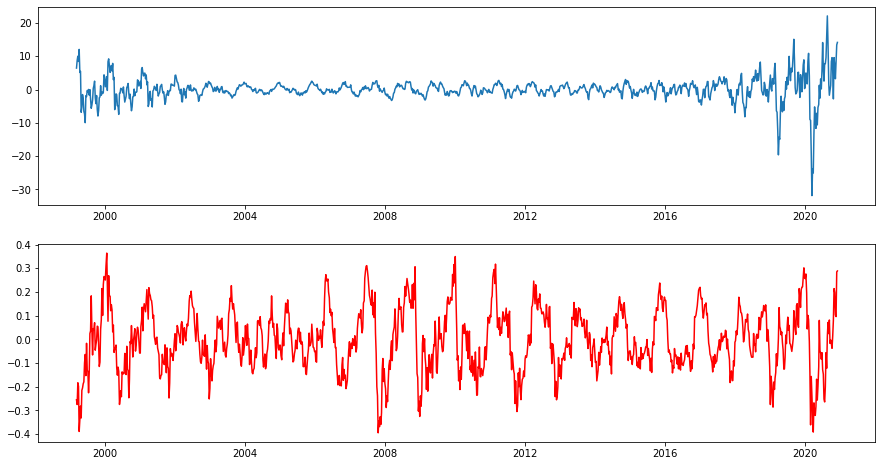

In [14]:
## seasonal
fig, ax = plt.subplots(2,figsize=(15,8))
ax[0].plot(qqq_seasonal)
ax[1].plot(us30y_seasonal, color = 'r');

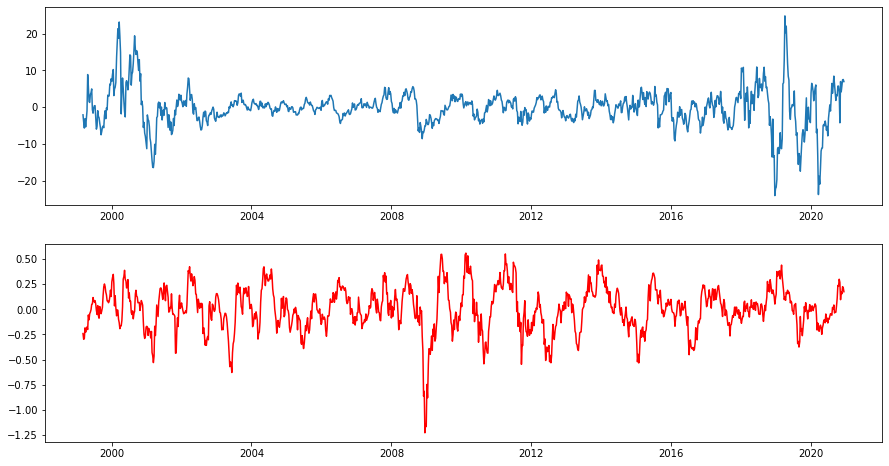

In [15]:
## resid
fig, ax = plt.subplots(2,figsize=(15,8))
ax[0].plot(qqq_resid)
ax[1].plot(us30y_resid, color = 'r');

In [16]:
# helper
def fit_poly(X,y,k):
    # Transforms our data to allow for Polynomial regression (Matrix from last class)
    poly = PolynomialFeatures(k)
    X_poly = poly.fit_transform(X.reshape(-1,1))
    # Linear Regression Model
    lr = LinearRegression()
    lr.fit(X_poly,y)
    return lr

### Polinomial Regression k = 2

In [17]:
## importing modules
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.evaluate import bias_variance_decomp


Coeficients:[   0.         -170.47677235   17.25211723], 
Intercept:463.33908937409115
y = 463.33908937409115x^0+-170.47677234605123x^1+17.252117229655482x^2


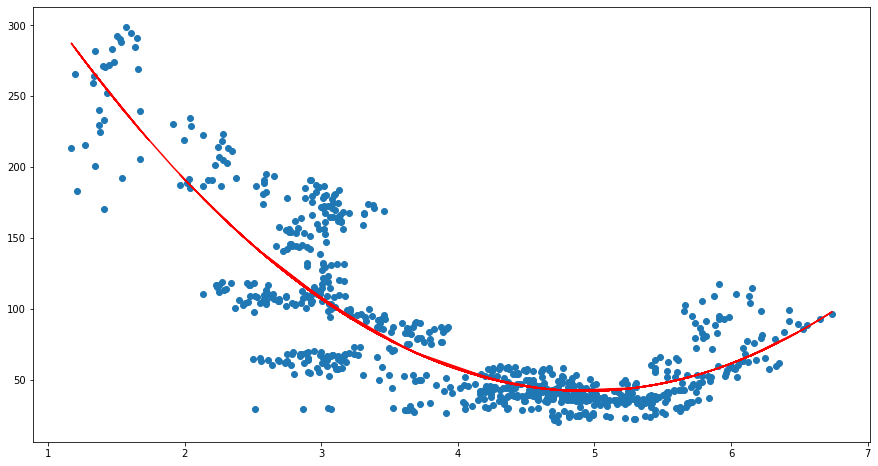

In [18]:
# double splitting
X, y = df[['US30Y']].values,df['QQQ'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=2)

# Calling
lr = fit_poly(X_train,y_train,2)

# Variables regression 
print(f'Coeficients:{lr.coef_}, \nIntercept:{lr.intercept_}')

# The function
b0,b1,b2 = lr.coef_
b0 = lr.intercept_
lr_func = lambda x: b0*x**0 + b1*x**1 + b2*x**2
print(f"y = {b0}x^0+{b1}x^1+{b2}x^2")

# plotting on train 
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(X_train,y_train)
plt.plot(X, lr_func(X),c="red");

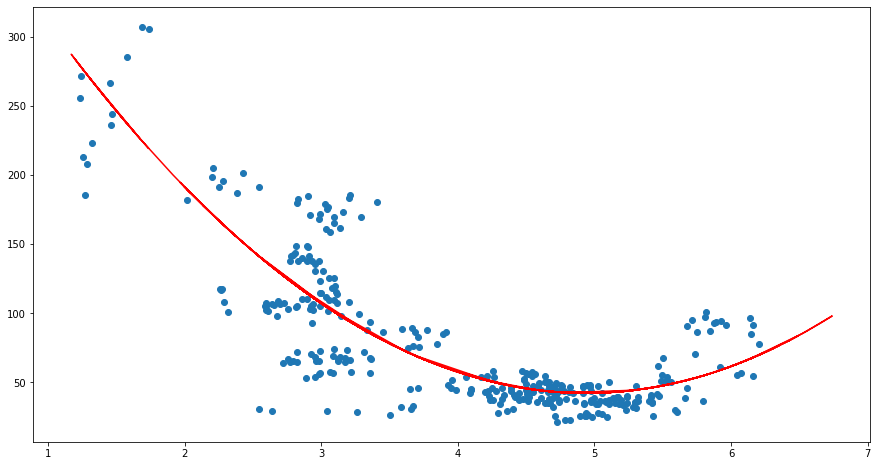

In [19]:
# plotting on test
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(X_test,y_test)
plt.plot(X, lr_func(X),c="red");

In [20]:
## Metrics
from sklearn.metrics import r2_score
pre_process = PolynomialFeatures(degree=2)
test_y_pred = lr.predict(pre_process.fit_transform(X_test))

r2_test = r2_score(y_true=y_test, y_pred=test_y_pred )
print(f'R2:{r2_test}')

R2:0.7005174721770199


## Polinomial Regression 2 Lagged QQQ

In [21]:
leading1 = df[['US30Y']][:-12]
lagged1 = df['QQQ'][12:]

Coeficients:[   0.         -180.14230045   18.28577647], 
Intercept:485.46331393376
y = 485.46331393376x^0+-180.1423004499562x^1+18.285776472916325x^2


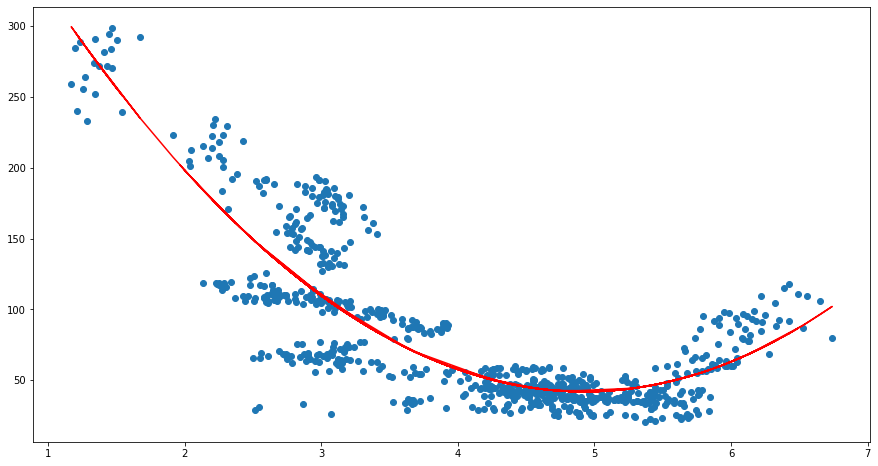

In [22]:
# double splitting
X, y = leading1.values,lagged1.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=2)

# Calling
lr = fit_poly(X_train,y_train,2)

# Variables regression 
print(f'Coeficients:{lr.coef_}, \nIntercept:{lr.intercept_}')

# The function
b0,b1,b2 = lr.coef_
b0 = lr.intercept_
lr_func = lambda x: b0*x**0 + b1*x**1 + b2*x**2
print(f"y = {b0}x^0+{b1}x^1+{b2}x^2")

# plotting on train 
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(X_train,y_train)
plt.plot(X, lr_func(X),c="red");

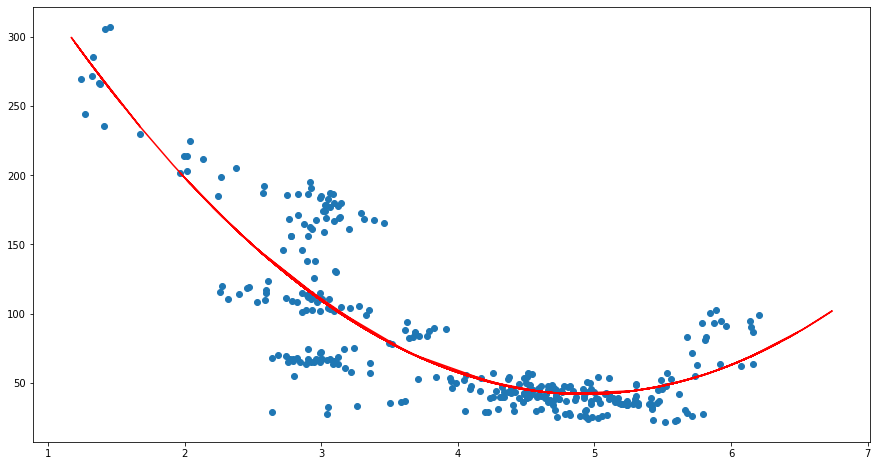

In [23]:
# plotting on test
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(X_test,y_test)
plt.plot(X, lr_func(X),c="red");

In [24]:
## Metrics
from sklearn.metrics import r2_score
pre_process = PolynomialFeatures(degree=2)
test_y_pred = lr.predict(pre_process.fit_transform(X_test))

r2_test = r2_score(y_true=y_test, y_pred=test_y_pred )
print(f'R2:{r2_test}')

R2:0.7150236436120581


### Polinomial Regression  Lagged QQQ

Coeficients:[   0.         -180.14230045   18.28577647], 
Intercept:485.46331393376
y = 485.46331393376x^0+-180.1423004499562x^1+18.285776472916325x^2
R2:0.7150236436120581


(0.7150236436120581,
 485.46331393376,
 array([   0.        , -180.14230045,   18.28577647]))

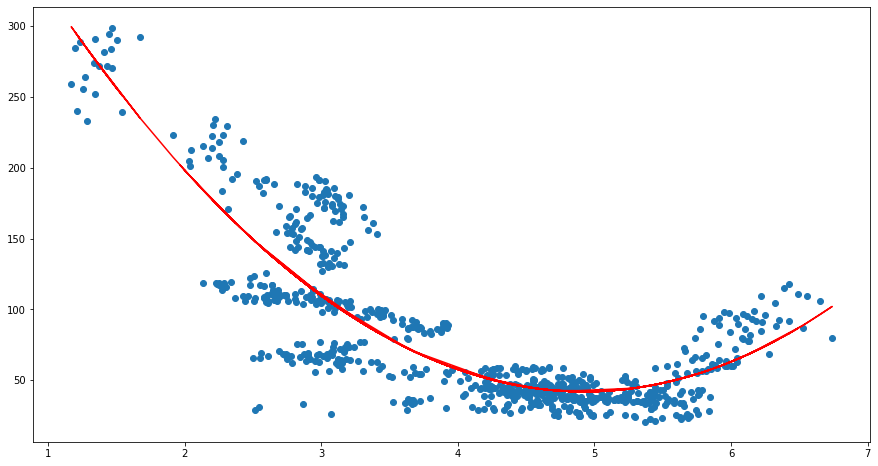

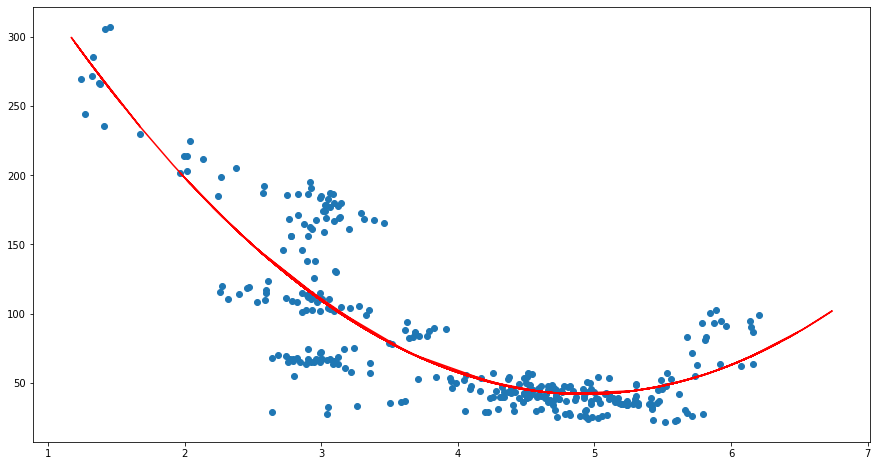

In [25]:
# double splitting
X, y = leading1.values,lagged1.values

def polinomial2_regression (X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=2)

    # Calling
    lr = fit_poly(X_train,y_train,2)

    # Variables regression 
    print(f'Coeficients:{lr.coef_}, \nIntercept:{lr.intercept_}')

    # The function
    b0,b1,b2 = lr.coef_
    b0 = lr.intercept_
    lr_func = lambda x: b0*x**0 + b1*x**1 + b2*x**2
    print(f"y = {b0}x^0+{b1}x^1+{b2}x^2")

    # plotting on train 
    fig, ax = plt.subplots(figsize=(15,8))
    plt.scatter(X_train,y_train)
    plt.plot(X, lr_func(X),c="red");

    # plotting on test
    fig, ax = plt.subplots(figsize=(15,8))
    plt.scatter(X_test,y_test)
    plt.plot(X, lr_func(X),c="red");

    pre_process = PolynomialFeatures(degree=2)
    test_y_pred = lr.predict(pre_process.fit_transform(X_test))

    r2_test = r2_score(y_true=y_test, y_pred=test_y_pred )
    print(f'R2:{r2_test}')
    
    return (r2_test,lr.intercept_,lr.coef_)

polinomial2_regression(leading1.values,lagged1.values)

In [26]:
pre_process.fit_transform(X_test)

array([[ 1.        ,  4.66699982, 21.78088732],
       [ 1.        ,  2.9976    ,  8.98560576],
       [ 1.        ,  1.4161    ,  2.00533921],
       ...,
       [ 1.        ,  5.78700018, 33.48937108],
       [ 1.        ,  5.51599979, 30.42625368],
       [ 1.        ,  3.50099993, 12.25700051]])

In [37]:
df[['date']][-1:]

,date
date,
2020-12-07 14:30:00+00:00,2020-12-07 14:30:00+00:00
